## Import Libraries

In [1]:
import nltk
import tensorflow as tf
import keras
from gensim.models import Word2Vec
import multiprocessing
import os
from keras.initializers import Constant
import matplotlib.pyplot as plt
import keras.backend as K
from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint,EarlyStopping

Using TensorFlow backend.
C:\Program Files\Python36\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


### Custom Method for F1 Score and Accuracy(Ignoring Paddings)

In [2]:
def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    # tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp )
    r = tp / (tp + fn )

    f1 = 2*p*r / (p+r)
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def ignore_class_accuracy(to_ignore=0):
    def ignore_accuracy(y_true, y_pred):
        y_true_class = K.argmax(y_true, axis=-1)
        y_pred_class = K.argmax(y_pred, axis=-1)
 
        ignore_mask = K.cast(K.not_equal(y_pred_class, to_ignore), 'int32')
        matches = K.cast(K.equal(y_true_class, y_pred_class), 'int32') * ignore_mask
        accuracy = K.sum(matches) / K.maximum(K.sum(ignore_mask), 1)
        return accuracy
    return ignore_accuracy

### Importing Data from Penn Treebank Dataset

In [3]:
tagged_sentences = nltk.corpus.treebank.tagged_sents()
 
print(tagged_sentences[0])
print("Tagged sentences: ", len(tagged_sentences))
print("Tagged words:", len(nltk.corpus.treebank.tagged_words()))

[('Pierre', 'NNP'), ('Vinken', 'NNP'), (',', ','), ('61', 'CD'), ('years', 'NNS'), ('old', 'JJ'), (',', ','), ('will', 'MD'), ('join', 'VB'), ('the', 'DT'), ('board', 'NN'), ('as', 'IN'), ('a', 'DT'), ('nonexecutive', 'JJ'), ('director', 'NN'), ('Nov.', 'NNP'), ('29', 'CD'), ('.', '.')]
Tagged sentences:  3914
Tagged words: 100676


### Pre-processing of Data

In [4]:
import numpy as np
 
sentences, sentence_tags =[], [] 
for tagged_sentence in tagged_sentences:
    sentence, tags = zip(*tagged_sentence)
    sentences.append(sentence)
    sentence_tags.append(tags)
print(sentences[:3])
print(sentence_tags[5])
# ['Lorillard' 'Inc.' ',' 'the' 'unit' 'of' 'New' 'York-based' 'Loews'
#  'Corp.' 'that' '*T*-2' 'makes' 'Kent' 'cigarettes' ',' 'stopped' 'using'
#  'crocidolite' 'in' 'its' 'Micronite' 'cigarette' 'filters' 'in' '1956'
# '.']
# ['NNP' 'NNP' ',' 'DT' 'NN' 'IN' 'JJ' 'JJ' 'NNP' 'NNP' 'WDT' '-NONE-' 'VBZ'
#  'NNP' 'NNS' ',' 'VBD' 'VBG' 'NN' 'IN' 'PRP$' 'NN' 'NN' 'NNS' 'IN' 'CD'
#  '.']]

[('Pierre', 'Vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'Nov.', '29', '.'), ('Mr.', 'Vinken', 'is', 'chairman', 'of', 'Elsevier', 'N.V.', ',', 'the', 'Dutch', 'publishing', 'group', '.'), ('Rudolph', 'Agnew', ',', '55', 'years', 'old', 'and', 'former', 'chairman', 'of', 'Consolidated', 'Gold', 'Fields', 'PLC', ',', 'was', 'named', '*-1', 'a', 'nonexecutive', 'director', 'of', 'this', 'British', 'industrial', 'conglomerate', '.')]
('NNP', 'NNP', ',', 'DT', 'NN', 'IN', 'JJ', 'JJ', 'NNP', 'NNP', 'WDT', '-NONE-', 'VBZ', 'NNP', 'NNS', ',', 'VBD', 'VBG', 'NN', 'IN', 'PRP$', 'NN', 'NN', 'NNS', 'IN', 'CD', '.')


### Building Dictionary, Adding Padding and Out of Vocabulary

In [5]:
from sklearn.model_selection import train_test_split
 
train_sentences, test_sentences, train_tags, test_tags = train_test_split(sentences, sentence_tags, test_size=0.2)

words, tags = set([]), set([])
 
for s in train_sentences:
    for w in s:
        words.add(w.lower())

for ts in train_tags:
    for t in ts:
        tags.add(t)

word2index = {w: i + 2 for i, w in enumerate(list(words))}
word2index['-PAD-'] = 0  # The special value used for padding
word2index['-OOV-'] = 1  # The special value used for OOVs
 
tag2index = {t: i + 1 for i, t in enumerate(list(tags))}
tag2index['-PAD-'] = 0  # The special value used to padding

## Model Parameters for Word2Vec

In [6]:
#Declare Model Parameters
cbow = 0
skipgram = 1
EMB_DIM = 300 #more dimensions, more computationally expensive to train
min_word_count = 1
workers = multiprocessing.cpu_count() #based on computer cpu count
context_size = 7
downsampling = 1e-3
learning_rate = 0.025 #initial learning rate
min_learning_rate = 0.025 #fixated learning rate
num_epoch = 15

In [7]:
w2v = Word2Vec(
    sg = skipgram,
    hs = 1, #hierarchical softmax
    size = EMB_DIM,
    min_count = min_word_count, 
    workers = workers,
    window = context_size, 
    sample = downsampling, 
    alpha = learning_rate, 
    min_alpha = min_learning_rate
)
print('Vocabulary size: %d' % len(words))
w2v.build_vocab(train_sentences)
w2v.train(train_sentences,epochs=10,total_examples=w2v.corpus_count)
words = list(w2v.wv.vocab)
# save model in ASCII (word2vec) format
filename = 'embedding_word2vec.txt'
w2v.wv.save_word2vec_format(filename, binary=False)

Vocabulary size: 10103


In [8]:
embeddings_index={}
f=open(os.path.join('','embedding_word2vec.txt '),encoding="utf-8")
for line in f:
    values=line.split()
    word=values[0]
    coefs=np.asarray(values[1:])
    embeddings_index[word]=coefs
f.close()

In [9]:
train_sentences_X, test_sentences_X, train_tags_y, test_tags_y = [], [], [], []

num_words=len(word2index)+1
embedding_matrix=np.zeros((num_words,EMB_DIM))
print(word2index)
for word,i in word2index.items():
    if i>num_words:
        continue
    embedding_vector=embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i]=embedding_vector

for s in train_sentences:
    s_int = []
    for w in s:
        try:
            s_int.append(word2index[w.lower()])
        except KeyError:
            s_int.append(word2index['-OOV-'])
 
    train_sentences_X.append(s_int)

for s in test_sentences:
    s_int = []
    for w in s:
        try:
            s_int.append(word2index[w.lower()])
        except KeyError:
            s_int.append(word2index['-OOV-'])
 
    test_sentences_X.append(s_int)

for s in train_tags:
    train_tags_y.append([tag2index[t] for t in s])

for s in test_tags:
    test_tags_y.append([tag2index[t] for t in s])

print(train_sentences_X[0])
print(test_sentences_X[0])
print(train_tags_y[0])
print(test_tags_y[0])



{'vinyl': 2, 'waste': 3, 'passbook': 4, 'semiliterate': 5, '135': 6, 'grade': 7, 'battered': 8, 'block': 9, 'frequently': 10, 'perignon': 11, 'defeat': 12, 'rail': 13, 'unrealistically': 14, 'mechanically': 15, 'reduce': 16, 'three-month': 17, 'jones': 18, 'acid-rain': 19, 'refer': 20, 'campaigner': 21, 'sweeping': 22, 'rise': 23, 'relation': 24, 'dodger': 25, 'nomenklatura': 26, 'steps': 27, 'test-practice': 28, 'emphasis': 29, 'hopwood': 30, 'investors': 31, 'selected': 32, 'economies': 33, 'facing': 34, 'minimum': 35, 'lambert': 36, 'intoxication': 37, 'daiwa': 38, '3.19': 39, 'material': 40, '11.6': 41, '5': 42, 'paper': 43, 'fuels': 44, 'economist': 45, 'islamabad': 46, 'fanfare': 47, 'later': 48, 'billion': 49, 'stake': 50, 'agenda': 51, '64.5': 52, '7.88': 53, 'smoking': 54, 'mention': 55, 'unneeded': 56, 'clara': 57, '*t*-44': 58, 'abortion': 59, 'arrangements': 60, 'spend': 61, 'cannell': 62, 'elsewhere': 63, 'alert': 64, 'variables': 65, 'burden': 66, 'near': 67, 'documents':

[119, 7339, 4131, 385, 3411, 9263, 3065, 4458, 510, 3223, 6910, 3177, 5226, 1893, 7464, 3054, 3506, 9848, 2493, 4181, 5674]
[2572, 9274, 6326, 3411, 1973, 6222, 1, 5664, 1, 1644, 8398, 1973, 610, 1233, 3713, 6916, 8470, 5068, 6839, 4711, 7418, 1, 784, 1, 6230, 6789, 4711, 1644, 1, 5674]
[10, 30, 10, 29, 10, 40, 17, 8, 4, 8, 33, 8, 4, 4, 11, 45, 45, 28, 4, 8, 43]
[10, 10, 10, 10, 37, 27, 28, 18, 25, 8, 8, 37, 40, 28, 5, 40, 25, 8, 4, 25, 8, 8, 27, 28, 31, 22, 25, 8, 8, 43]


In [10]:
MAX_LENGTH = len(max(train_sentences_X, key=len))
print(MAX_LENGTH)  # 271

from keras.preprocessing.sequence import pad_sequences
 
train_sentences_X = pad_sequences(train_sentences_X, maxlen=MAX_LENGTH, padding='post')
test_sentences_X = pad_sequences(test_sentences_X, maxlen=MAX_LENGTH, padding='post')
train_tags_y = pad_sequences(train_tags_y, maxlen=MAX_LENGTH, padding='post')
test_tags_y = pad_sequences(test_tags_y, maxlen=MAX_LENGTH, padding='post')
 
print(train_sentences_X[0])
print(test_sentences_X[0])
print(train_tags_y[0])
print(test_tags_y[0])

271
[ 119 7339 4131  385 3411 9263 3065 4458  510 3223 6910 3177 5226 1893
 7464 3054 3506 9848 2493 4181 5674    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
  

In [11]:
from keras.models import Sequential
from keras.layers import Dense, CuDNNLSTM,LSTM, InputLayer, Bidirectional, TimeDistributed, Embedding, Activation,Dropout
from keras.optimizers import Adam

model = Sequential()
embedding_layer=Embedding(num_words,EMB_DIM,embeddings_initializer=Constant(embedding_matrix),input_length=MAX_LENGTH,trainable=True)
model.add(InputLayer(input_shape=(MAX_LENGTH, )))
model.add(embedding_layer)
model.add(Bidirectional(CuDNNLSTM(256, return_sequences=True)))
model.add(Dropout(0.3))
model.add(TimeDistributed(Dense(len(tag2index),activation="relu")))
model.add(Activation('softmax'))
 
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(0.001),
              metrics=["accuracy",f1,ignore_class_accuracy(0)])
 
model.summary()
plot_model(model, to_file='model.png')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 271, 300)          3031800   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 271, 512)          1142784   
_________________________________________________________________
dropout_1 (Dropout)          (None, 271, 512)          0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 271, 47)           24111     
_________________________________________________________________
activation_1 (Activation)    (None, 271, 47)           0         
Total params: 4,198,695
Trainable params: 4,198,695
Non-trainable params: 0
_________________________________________________________________


In [12]:
def to_categorical(sequences, categories):
    cat_sequences = []
    for s in sequences:
        cats = []
        for item in s:
            cats.append(np.zeros(categories))
            cats[-1][item] = 1.0
        cat_sequences.append(cats)
    return np.array(cat_sequences)


cat_train_tags_y = to_categorical(train_tags_y, len(tag2index))
print(cat_train_tags_y[0])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


In [13]:
es = EarlyStopping(monitor='val_ignore_accuracy', mode='max', verbose=1,patience=5)
history=model.fit(train_sentences_X, to_categorical(train_tags_y, len(tag2index)), batch_size=256, epochs=100,callbacks=[es],validation_data=(test_sentences_X, to_categorical(test_tags_y, len(tag2index))))

Train on 3131 samples, validate on 783 samples
Epoch 1/100
3131/3131 [==============================] - 36s 12ms/step - loss: 2.0367 - acc: 0.8831 - f1: 0.0098 - ignore_accuracy: 0.0791 - val_loss: 0.4088 - val_acc: 0.9064 - val_f1: 0.0204 - val_ignore_accuracy: 0.1401
Epoch 2/100
3131/3131 [==============================] - 16s 5ms/step - loss: 0.3542 - acc: 0.9149 - f1: 0.0207 - ignore_accuracy: 0.1311 - val_loss: 0.3269 - val_acc: 0.9142 - val_f1: 0.0210 - val_ignore_accuracy: 0.1533
Epoch 3/100
3131/3131 [==============================] - 15s 5ms/step - loss: 0.3041 - acc: 0.9201 - f1: 0.0210 - ignore_accuracy: 0.1735 - val_loss: 0.3011 - val_acc: 0.9255 - val_f1: 0.0211 - val_ignore_accuracy: 0.2672
Epoch 4/100
3131/3131 [==============================] - 15s 5ms/step - loss: 0.2869 - acc: 0.9257 - f1: 0.0211 - ignore_accuracy: 0.2320 - val_loss: 0.2884 - val_acc: 0.9307 - val_f1: 0.0210 - val_ignore_accuracy: 0.3251
Epoch 5/100
3131/3131 [==============================] - 16s 5ms

3131/3131 [==============================] - 15s 5ms/step - loss: 0.0399 - acc: 0.9901 - f1: 0.0922 - ignore_accuracy: 0.9262 - val_loss: 0.0719 - val_acc: 0.9835 - val_f1: 0.0850 - val_ignore_accuracy: 0.8757
Epoch 38/100
3131/3131 [==============================] - 15s 5ms/step - loss: 0.0394 - acc: 0.9902 - f1: 0.0924 - ignore_accuracy: 0.9283 - val_loss: 0.0718 - val_acc: 0.9835 - val_f1: 0.0850 - val_ignore_accuracy: 0.8777
Epoch 39/100
3131/3131 [==============================] - 16s 5ms/step - loss: 0.0391 - acc: 0.9902 - f1: 0.0927 - ignore_accuracy: 0.9292 - val_loss: 0.0722 - val_acc: 0.9835 - val_f1: 0.0850 - val_ignore_accuracy: 0.8771
Epoch 40/100
3131/3131 [==============================] - 15s 5ms/step - loss: 0.0388 - acc: 0.9903 - f1: 0.0928 - ignore_accuracy: 0.9309 - val_loss: 0.0709 - val_acc: 0.9836 - val_f1: 0.0852 - val_ignore_accuracy: 0.8796
Epoch 41/100
3131/3131 [==============================] - 15s 5ms/step - loss: 0.0385 - acc: 0.9903 - f1: 0.0927 - ignore

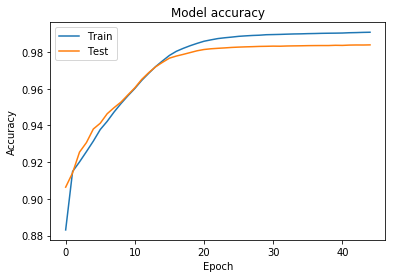

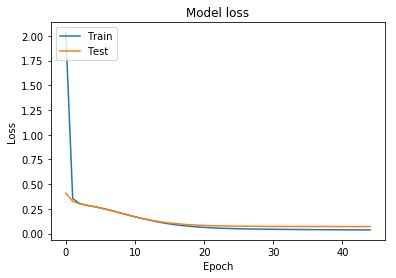

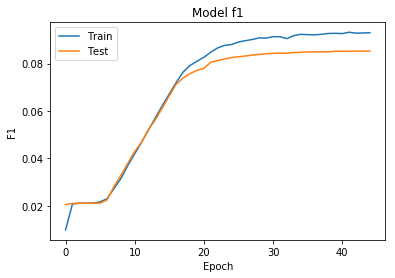

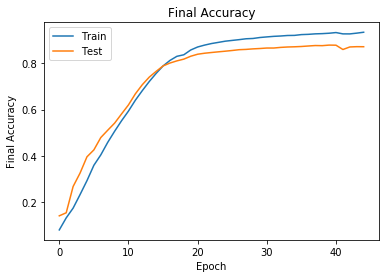

In [14]:
# Plot training & validation accuracy values
plt.figure()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig("fake_acc.png")

# Plot training & validation loss values
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig("loss.png")

# Plot training & validation loss values
plt.figure()
plt.plot(history.history['f1'])
plt.plot(history.history['val_f1'])
plt.title('Model f1')
plt.ylabel('F1')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig("f1.png")

# Plot training & validation loss values
plt.figure()
plt.plot(history.history['ignore_accuracy'])
plt.plot(history.history['val_ignore_accuracy'])
plt.title('Final Accuracy')
plt.ylabel('Final Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig("real_acc.png")

In [15]:
scores = model.evaluate(test_sentences_X, to_categorical(test_tags_y, len(tag2index)))
print(model.metrics_names)   # acc: 99.09751977804825   
print(scores)   # acc: 99.09751977804825

783/783 [==============================] - 2s 3ms/step
['loss', 'acc', 'f1', 'ignore_accuracy']
[0.07140853628991968, 0.9838684583380153, 0.050265363164217536, 0.8727819699124076]


In [16]:
test_samples = [
    "running is very important for me .".split(),
    "I was running every day for a month .".split()
]
print(test_samples)
 
# [['running', 'is', 'very', 'important', 'for', 'me', '.'], ['I', 'was', 'running', 'every', 'day', 'for', 'a', 'month', '.']]
 
test_samples_X = []
for s in test_samples:
    s_int = []
    for w in s:
        try:
            s_int.append(word2index[w.lower()])
        except KeyError:
            s_int.append(word2index['-OOV-'])
    test_samples_X.append(s_int)

test_samples_X = pad_sequences(test_samples_X, maxlen=MAX_LENGTH, padding='post')


predictions = model.predict(test_samples_X)
def logits_to_tokens(sequences, index):
    token_sequences = []
    for categorical_sequence in sequences:
        token_sequence = []
        for categorical in categorical_sequence:
            token_sequence.append(index[np.argmax(categorical)])
 
        token_sequences.append(token_sequence)
 
    return token_sequences


final_pred=logits_to_tokens(predictions, {i: t for t, i in tag2index.items()})
for x in range(len(test_samples)):
    print(test_samples[x])
    print(final_pred[x][0:len(test_samples[x])])

[['running', 'is', 'very', 'important', 'for', 'me', '.'], ['I', 'was', 'running', 'every', 'day', 'for', 'a', 'month', '.']]
['running', 'is', 'very', 'important', 'for', 'me', '.']
['VBG', 'VBZ', 'RB', 'JJ', 'IN', 'PRP', '-PAD-']
['I', 'was', 'running', 'every', 'day', 'for', 'a', 'month', '.']
['PRP', 'VBD', 'VBG', 'DT', 'NN', 'IN', 'DT', 'NN', '-PAD-']
